# Plan-and-Execute 

The core idea is to first come up with a multi-step plan, and then go through that plan one item at a time. After accomplishing a particular task, you can then revisit the plan and modify as appropriate.

paper:
https://arxiv.org/abs/2305.04091

source:
https://github.com/langchain-ai/langgraph/blob/c7306f7aed68334a4287b4eed9c05444e4b095a6/docs/docs/tutorials/plan-and-execute/plan-and-execute.ipynb

In [16]:
### define tools 
import os
import yaml
import requests
from langchain.tools import tool
from xml.etree import ElementTree
from duckduckgo_search import DDGS

@tool
def arxiv_search_tool(query: str) -> list:
    """Search Arxiv for the given query and return a list of results (title: url)."""
    url = "http://export.arxiv.org/api/query"
    params = {"search_query": query, "start": 0, "max_results": 5}
    try:
        resp = requests.get(url, params=params, timeout=10)
        resp.raise_for_status()
        root = ElementTree.fromstring(resp.content)
        ns = {'atom': 'http://www.w3.org/2005/Atom'}
        results = []
        for entry in root.findall('atom:entry', ns):
            title_elem = entry.find('atom:title', ns)
            link_elem = entry.find('atom:id', ns)
            title = title_elem.text.strip() if title_elem is not None else "No Title"
            link = link_elem.text.strip() if link_elem is not None else ""
            if link:
                results.append(f"{title}: {link}")
        return results or ["Arxiv: No relevant results found."]
    except Exception as e:
        return [f"Arxiv search error: {e}"]

@tool
def duckduckgo_search_tool(query: str) -> list:
    """Search DuckDuckGo for the given query and return a list of results."""
    try:
        # Use DDGS for robust search, region set to 'cn-zh' for Chinese
        results = DDGS().text(query, region="cn-zh", safesearch="off", max_results=10)
        output = []
        for item in results:
            title = item.get('title')
            url = item.get('href')
            if title and url:
                output.append(f"{title}: {url}")
        return output or ["DuckDuckGo: No relevant results found."]
    except Exception as e:
        return [f"DuckDuckGo search error: {e}"]

tools = [arxiv_search_tool, duckduckgo_search_tool]


In [30]:
### define execution agent
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(
    base_url="https://api.deepseek.com", 
    api_key="sk-3b458ee0624f41e1b8c589e74be23e44",
    model_name="deepseek-chat"
    )

# llm = ChatOpenAI(
#     base_url="https://api.siliconflow.cn/v1",
#     model="Qwen/Qwen2.5-72B-Instruct",
#     api_key="sk-ykbiglqspirbapnzjvrasbuhboizzqhhhjupwcwxkvhcktod"
# )

result = llm.invoke('Hello, how are you?')
result.pretty_print()
researcher_agent = create_react_agent(llm, tools)

================================== Ai Message ==================================

Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you with anything you need. 😊 How about you? How are you doing today?


In [18]:
researcher_agent.invoke({"messages": [("user", "who is the winnner of the us open")]})

{'messages': [HumanMessage(content='who is the winnner of the us open', additional_kwargs={}, response_metadata={}, id='b31b477f-4d52-4e7a-af74-67bde01deed8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '01971b69652ad5d42954cee1dbf646c6', 'function': {'arguments': '{"query": "2023 US Open winner"}', 'name': 'duckduckgo_search_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 264, 'total_tokens': 294, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen2.5-72B-Instruct', 'system_fingerprint': '', 'id': '01971b695e160b10bd591564fde851a1', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--73f80672-4661-41e7-8a4f-77fed99a332b-0', tool_calls=[{'name': 'duckduckgo_search_tool', 'args': {'query': '2023 US Open winner'}, 'id': '01971b69652ad5d42954cee1dbf646c6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 264, 'output_

### Define the State and Planning Step

State definition.

First, we will need to track the **current plan**. Let's represent that as a list of strings.

Next, we should track previously **executed steps**. Let's represent that as a list of tuples (these tuples will contain the step and then the result)

Finally, we need to have some state to represent the final response as well as the original input.


In [19]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [31]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

planner = planner_prompt | llm.with_structured_output(Plan)


In [ ]:
import json

try:
    response = planner.invoke({"messages": [("user", "what is the hometown of the current Australia open winner?")]})
    print(json.dumps(response, indent=2))
except Exception as e:
    print(f"An error occurred: {e}")


UnprocessableEntityError: Failed to deserialize the JSON body into the target type: response_format: response_format.type `json_schema` is unavailable now at line 1 column 858

### Re-Plan Step



In [23]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | llm.with_structured_output(Act)

## Create the Graph

In [24]:
from typing import Literal
from langgraph.graph import StateGraph, START, END

async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

def build_graph():
    workflow = StateGraph(PlanExecute)

    # Add the plan node
    workflow.add_node("planner", plan_step)
    # Add the execution step
    workflow.add_node("agent", execute_step)
    # Add a replan node
    workflow.add_node("replan", replan_step)
    workflow.add_edge(START, "planner")
    # From plan we go to agent
    workflow.add_edge("planner", "agent")
    # From agent, we replan
    workflow.add_edge("agent", "replan")
    workflow.add_conditional_edges(
        "replan",
        # Next, we pass in the function that will determine which node is called next.
        should_end,
        ["agent", END],
    )

    # Finally, we compile it!
    # This compiles it into a LangChain Runnable,
    # meaning you can use it as you would any other runnable
    app = workflow.compile()
    return app

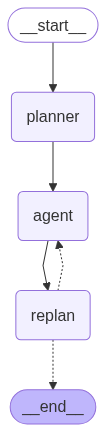

In [25]:

from IPython.display import Image, display

app = build_graph()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the mens 2024 Australia open winner?"}

async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

ValidationError: 1 validation error for Plan
  Input should be an object [type=model_type, input_value=1.3010521711127168, input_type=float]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type